# 거래 흐름 기반 Liquidity & Pathway 분석

## 1. 개요
본 분석의 목적은 **PaySim 시뮬레이션 금융 거래 데이터**를 활용하여 거래의 **유입·유출 구조**, **경로별 흐름**, 그리고 **현금화 속도**를 탐색하는 것이다.  

이 분석은 단순히 Fraud 거래의 빈도나 비율을 파악하는 것을 넘어,  
자금이 **어디로 흘러가고**, **어떤 경로를 거쳐 이동하며**, **얼마나 빠르게 현금화되는가**를 구조적으로 이해하는 데 초점을 둔다.  

---

## 2. 분석 목표

1. **자금의 유입·유출 구조 (Liquidity Flow)**  
   - 송신자(`nameOrig`)와 수신자(`nameDest`) 기준으로 자금의 유입(Inflow)과 유출(Outflow)을 계산하고, 사용자별 **순유동성(Net Liquidity)** 을 도출한다.

2. **경로별 흐름 (Pathway Network)**  
   - 거래를 **네트워크 그래프 구조**로 모델링하여 자금의 이동 경로와 Fraud 집중 경향을 분석한다.

3. **현금화 속도 (Liquidity Turnover Speed)**  
   - 동일 송신자의 연속 거래 간 시간(`step`) 간격을 이용해 평균 현금화 속도를 계산하고 Fraud 거래와 정상 거래의 차이를 비교한다.

---

## 3. 분석 핵심 질문

| 구분 | 주요 질문 |
|------|------------|
| 유입·유출 구조 | 특정 사용자는 자금을 주로 보내는가, 받는가? |
| 경로별 흐름 | Fraud 거래는 특정 경로 또는 노드에 집중되는가? |
| 현금화 속도 | 사기 거래는 정상 거래보다 빠르게 현금화되는가? |

---

## 4. 기대 효과
- Fraud 탐지 모델링 이전 단계에서 **거래 흐름의 구조적 이상 패턴**을 조기 파악  
- **유입-유출 불균형**, **단방향 흐름**, **짧은 현금화 시간** 등의 행동적·구조적 특성을 Fraud 리스크 지표로 활용할 수 있다.

In [9]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pymysql
from sqlalchemy import create_engine
from sqlalchemy import text

user = 'root'
password = 'doyeon5345'
host = 'localhost'
port = 3306
db = 'paysim'

try:
    engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{db}')
    print("MySQL 연결 성공")
except Exception as e:
    print("연결 실패:", e)

MySQL 연결 성공


## 1️⃣ 자금의 유입·유출 구조 분석

1. **유입(Inflow)**  
   - 각 사용자가 받은 총 금액(`SUM(amount WHERE nameDest=user)`) 계산  
   - 자금이 얼마나 들어왔는지 파악

2. **유출(Outflow)**  
   - 각 사용자가 보낸 총 금액(`SUM(amount WHERE nameOrig=user)`) 계산  
   - 자금이 얼마나 빠져나갔는지 확인

3. **순유동성(Net Liquidity)**  
   - `Inflow - Outflow`  
   - 양수면 자금이 유입된 상태, 음수면 자금이 유출된 상태

4. **분석 포인트**  
   - **Inflow↑, Outflow=0** → 자금 종착지(수신 허브)  
   - **Inflow=0, Outflow↑** → 송금형 사기 출발점  
   - **Inflow≈Outflow** → 정상 거래자


In [ ]:
# 1. 송신자 기준 유출 금액 (Outflow)
query_outflow = """
SELECT nameOrig AS user_id, 
       SUM(amount) AS total_outflow,
       COUNT(*) AS outflow_count
FROM paysim
GROUP BY nameOrig;
"""
df_outflow = pd.read_sql(query_outflow, engine)

# 2. 수신자 기준 유입 금액 (Inflow)
query_inflow = """
SELECT nameDest AS user_id, 
       SUM(amount) AS total_inflow,
       COUNT(*) AS inflow_count
FROM paysim
GROUP BY nameDest;
"""
df_inflow = pd.read_sql(query_inflow, engine)

# 3. 유입/유출 데이터 병합 및 순유동성(Net Liquidity) 계산
df_liquidity = pd.merge(df_inflow, df_outflow, how="outer", on="user_id").fillna(0)
df_liquidity["net_liquidity"] = df_liquidity["total_inflow"] - df_liquidity["total_outflow"]

# 4. 순유동성 상위 사용자(가장 많은 자금을 받은 계정) 확인
df_liquidity_sorted = df_liquidity.sort_values("net_liquidity", ascending=False)
df_liquidity_sorted.head(10)


,user_id,total_inflow,inflow_count,total_outflow,outflow_count,net_liquidity
23940,C12897728,6.857061e+07,5.0,0.0,0.0,6.857061e+07
99677,C274054575,5.524987e+07,4.0,0.0,0.0,5.524987e+07
92729,C2121530467,4.991770e+07,5.0,0.0,0.0,4.991770e+07
10658,C1128848873,4.964732e+07,5.0,0.0,0.0,4.964732e+07
43138,C1521873113,4.281815e+07,5.0,0.0,0.0,4.281815e+07
72657,C1878381014,4.279006e+07,4.0,0.0,0.0,4.279006e+07
51905,C1629025878,3.962709e+07,5.0,0.0,0.0,3.962709e+07
137087,C729866516,3.933433e+07,5.0,0.0,0.0,3.933433e+07
42381,C1512993148,3.697390e+07,1.0,0.0,0.0,3.697390e+07
30501,C1368361600,3.655061e+07,1.0,0.0,0.0,3.655061e+07


### 상위 유입 계정 특성
- 상위 계정들은 **유입(Inflow)** 은 많고 **유출(Outflow)** 은 전혀 없음.  
- 자금을 받기만 하고 다시 송금하지 않는 형태로, **자금의 종착지 또는 현금화 허브**로 작동할 가능성이 높음.

In [11]:
query_fraud_liq = """
SELECT t.nameOrig AS user_id, 
       MAX(t.isFraud) AS isFraud, 
       SUM(t.amount) AS total_tx_amount
FROM paysim t
GROUP BY t.nameOrig;
"""
df_fraud_flag = pd.read_sql(query_fraud_liq, engine)

# 병합: Fraud 플래그 + 유입/유출 구조
df_liquidity_fraud = pd.merge(df_liquidity, df_fraud_flag, how="left", on="user_id").fillna(0)

# Fraud vs Normal의 평균 순유동성 비교
df_liquidity_fraud.groupby("isFraud")[["total_inflow", "total_outflow", "net_liquidity"]].mean().round(2)


,total_inflow,total_outflow,net_liquidity
isFraud,,,
0.0,107803.07,106674.66,1128.42
1.0,0.00,1542736.85,-1542736.85


### Fraud vs Normal 비교
- 정상 거래는 유입과 유출이 거의 균형적.  
- Fraud 거래는 **유입 없이 대규모 유출**이 발생 → **자금 탈취·현금화 패턴**.

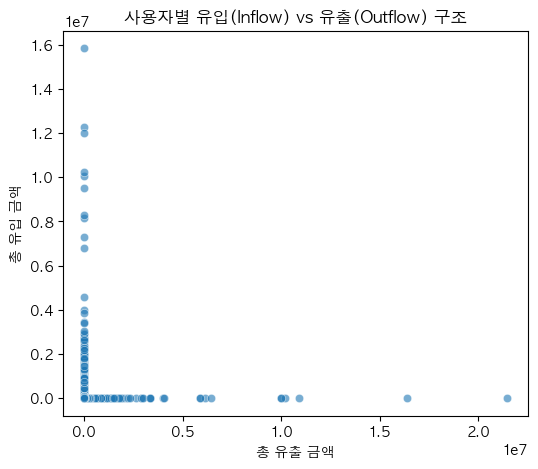

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.rcParams['font.family'] = 'AppleGothic'   
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_liquidity.sample(5000), x="total_outflow", y="total_inflow", alpha=0.6)
plt.title("사용자별 유입(Inflow) vs 유출(Outflow) 구조")
plt.xlabel("총 유출 금액")
plt.ylabel("총 유입 금액")
plt.show()

### 유입 vs 유출 구조 분포
- 대부분의 사용자가 **한 방향 거래만 수행**(유입만 또는 유출만 존재).  
- 거래 네트워크가 **입금자 → 수신자 → 종착 계정** 형태의 **단방향 자금 흐름 구조**로 작동하고 있음.

### ✅ 자금 유입/유출 구조 분석 결론
Fraud 거래는 **자금을 빼내는 순유출형 계정** 중심으로 발생하며, 이 계정들이 자금 흐름의 **마지막 단계(현금화 지점)** 역할을 하는 것으로 보인다.

## 2️⃣ 경로별 자금 흐름(Pathway) 분석

### 분석 단계
1. **네트워크 구성**  
   - 송신자(`nameOrig`)와 수신자(`nameDest`)를 노드로, 거래(`amount`, `isFraud`)를 엣지로 연결  
   - 방향성 그래프(`DiGraph`)를 통해 자금 이동 구조 모델링  

2. **자금 집중 경로 탐색**  
   - 여러 송신자 → 동일 수신자로 몰리는 구조 확인  
   - 자금이 모이는 허브형 계정 식별  

3. **단방향 흐름 분석**  
   - 송금전용·수신전용·양방향 계정 구분  
   - 자금의 순환 여부 및 흐름 방향 파악  

4. **이동 단계 분석**  
   - 송신자에서 수신자까지의 평균 이동 단계 계산  
   - 단발성 이동 vs 다단계 이동 구조 비교  

5. **Fraud 경로 비교**  
   - 정상 네트워크 대비 Fraud 네트워크의 연결도·집중도 비교  

### 분석 포인트
- **자금 집중 경로**: 여러 송신자의 거래가 한 수신자에게 몰리는가  
- **단방향 흐름**: Fraud 거래는 일방향 송금형 구조를 보이는가  
- **이동 단계**: Fraud 거래는 짧고 단순한 경로를 가지는가  
- **Fraud 구조 차이**: Fraud 네트워크는 제한된 계정 간 집중적 연결 구조를 보이는가


In [34]:
import networkx as nx

# 거래 데이터 로드 (자금 이동이 있는 거래만)
query = """
SELECT nameOrig, nameDest, amount, isFraud, type
FROM paysim
WHERE type IN ('TRANSFER', 'CASH_OUT');
"""
df_pathway = pd.read_sql(query, engine)
print("데이터 로드 완료:", df_pathway.shape)

# 네트워크 구성
G = nx.from_pandas_edgelist(
    df_pathway,
    source="nameOrig",
    target="nameDest",
    edge_attr=["amount", "isFraud", "type"],
    create_using=nx.DiGraph()
)

print("노드 수:", G.number_of_nodes(), "| 엣지 수:", G.number_of_edges())

데이터 로드 완료: (50303, 5)
노드 수: 84053 | 엣지 수: 43683


### 네트워크 개요
- **데이터 규모:** (50,303건, 5컬럼)  
- **노드 수:** 84,053  
- **엣지 수:** 43,683  

In [ ]:
# 자금 집중 경로 탐색
in_deg = pd.DataFrame(G.in_degree(), columns=["node", "in_degree"]).sort_values(by="in_degree", ascending=False)
print("\n[자금 유입 허브 Top 10]")
print(in_deg.head(10))


[자금 유입 허브 Top 10]
              node  in_degree
3948   C1085553281          5
12610  C1009406898          5
33483   C681078805          4
4244   C1269097316          4
20407  C1013700132          4
12647  C1040847151          4
21340  C1495761010          4
24847   C374195815          4
515    C1657041838          4
29955    C70895366          4


### 자금 유입 허브 탐색
- In-degree 최대값이 5에 불과하다는 점에서, 자금이 한두 곳으로 과도하게 집중되는 형태(=집금형 구조)는 아님. 즉, 일부 계정이 여러 번 입금을 받긴 했지만 허브로 기능할 만큼의 집중도는 낮음.
- 거래가 여러 계정을 거쳐 모이기보다는, 각 계정 간의 개별적 단발성 송금이 주를 이룸.
- 따라서 이번 데이터에서는 명확한 유입 허브(중심 계좌) 는 나타나지 않으며, 거래 네트워크가 전반적으로 분산적 구조를 가진 것으로 해석됨.

In [36]:
# 단방향 흐름 탐색 (송금전용 / 수신전용 / 양방향)
degree_df = pd.DataFrame({
    "node": list(G.nodes()),
    "in_degree": [G.in_degree(n) for n in G.nodes()],
    "out_degree": [G.out_degree(n) for n in G.nodes()]
})
degree_df["flow_type"] = degree_df.apply(
    lambda x: "송금전용" if x.out_degree > 0 and x.in_degree == 0 else
              "수신전용" if x.in_degree > 0 and x.out_degree == 0 else
              "양방향", axis=1
)
print("\n[계정 거래 방향 유형 분포]")
print(degree_df["flow_type"].value_counts())


[계정 거래 방향 유형 분포]
flow_type
송금전용    43683
수신전용    40370
Name: count, dtype: int64


### 단방향 흐름 분석
- 대부분의 계정이 **송금전용 또는 수신전용** 형태로 거래에 참여하며, 양방향 거래(송금·수신 모두 수행)는 매우 드묾.  
- 즉, 네트워크는 **순환 구조보다는 단방향성** 이 강함. 이러한 패턴은 **사기형 송금 네트워크**의 전형적인 특성과 유사함.

In [37]:
# 이동 단계 분석 (경로 길이 계산)
path_lengths = []
for component in nx.weakly_connected_components(G):
    subgraph = G.subgraph(component)
    for src, target in nx.edge_dfs(subgraph):
        try:
            length = nx.shortest_path_length(subgraph, src, target)
            path_lengths.append(length)
        except nx.NetworkXNoPath:
            continue

df_path_len = pd.DataFrame(path_lengths, columns=["path_length"])
print(f"\n평균 자금 이동 단계 수: {df_path_len['path_length'].mean():.2f}")
print(f"최대 이동 단계 수: {df_path_len['path_length'].max()}")



평균 자금 이동 단계 수: 1.00
최대 이동 단계 수: 1


### 이동 단계 분석
- **평균 자금 이동 단계 수:** 1.00  
- **최대 이동 단계 수:** 1  
→ 모든 거래가 **직접 송금(1단계)** 형태로만 발생.  
→ 자금이 여러 단계를 거치지 않고 **즉시 종착지로 도달**하는 구조로, 다단계 거래나 중개 노드는 거의 존재하지 않음.  
→ 이는 **간단한 송금 경로**를 통해 빠른 현금화가 이루어질 가능성을 의미함.

In [38]:
# Fraud 경로 집중도 비교
fraud_edges = df_pathway[df_pathway["isFraud"] == 1][["nameOrig", "nameDest", "amount"]]
G_fraud = nx.from_pandas_edgelist(
    fraud_edges,
    source="nameOrig",
    target="nameDest",
    edge_attr="amount",
    create_using=nx.DiGraph()
)

print("\n[Fraud 네트워크 요약]")
print("노드 수:", G_fraud.number_of_nodes())
print("엣지 수:", G_fraud.number_of_edges())

# Fraud 경로 집중도 계산
fraud_in = pd.DataFrame(G_fraud.in_degree(), columns=["node", "in_degree"])
fraud_hubs = fraud_in.sort_values(by="in_degree", ascending=False).head(5)
print("\n[Fraud 자금 집중 허브 Top 5]")
print(fraud_hubs)

# Fraud vs Normal 평균 경로 길이 비교
fraud_lengths = []
for component in nx.weakly_connected_components(G_fraud):
    subgraph = G_fraud.subgraph(component)
    for src, target in nx.edge_dfs(subgraph):
        try:
            fraud_lengths.append(nx.shortest_path_length(subgraph, src, target))
        except nx.NetworkXNoPath:
            continue

print(f"\nFraud 평균 경로 길이: {pd.Series(fraud_lengths).mean():.2f}")
print(f"Fraud 최대 경로 길이: {pd.Series(fraud_lengths).max()}")


[Fraud 네트워크 요약]
노드 수: 282
엣지 수: 141

[Fraud 자금 집중 허브 Top 5]
            node  in_degree
141  C1100722756          1
165  C1137450827          1
147  C1510391871          1
149  C2017082627          1
151   C671509828          1

Fraud 평균 경로 길이: 1.00
Fraud 최대 경로 길이: 1


### Fraud 네트워크 비교
- Fraud 네트워크는 전체 대비 규모가 매우 작고 단순한 구조를 보임.
- 대부분의 거래가 단일 송신자 → 단일 수신자 형태로, 복잡한 경로 없이 1단계(1-hop) 내에서 완료됨.
- 따라서 사기 거래는 짧고 직접적인 송금 중심 구조로, 자금이 여러 단계를 거치지 않고 한 번에 이동하는 특성이 뚜렷함.

### ✅ 결론
- 전체 네트워크와 Fraud 네트워크 모두 **단방향적이고 짧은 경로 중심 구조**를 가짐.  
- 따라서 사기 거래는 복잡한 경로를 거치지 않고 한 번의 송금으로 자금이 이동·종료되는 특성이 두드러짐.
- 이런 특징은 짧은 경로, 낮은 연결도, 분산된 송금 흐름으로 요약되며, 복잡한 자금 세탁보다는 **단기적·직접적인 이익 회수형 사기 구조**로 해석됨.

## 3️⃣ 현금화 속도 분석

1. 개요
   - 사용자가 **자금을 받은 후 다시 송금하기까지 걸린 평균 시간**  
   - Fraud 거래는 **짧은 간격으로 빠르게 현금화되는 경향**을 보임  

2. 계산 방식 
   - 동일 송신자(`nameOrig`) 기준으로 거래 시간(`step`) 정렬  
   - 연속 거래 간 시간 차이(Δtime) 계산  
   - 사용자별 평균 거래 간격을 구해 **평균 현금화 속도(avg_turnover_time)** 도출  
   - Fraud 여부(`isFraud`)별 평균 비교를 통해 차이 확인  

3. 해석
   - 평균 현금화 시간이 **짧을수록** 자금 이동이 빠른 구조  
   - Fraud 거래는 대부분 **자금 유입 직후 송금 또는 인출**이 발생  
   - 정상 거래는 거래 간격이 길거나 불규칙하여 **일반적 활동 패턴**을 보임  

4. 분석 포인트  
   - 현금화 속도 ↓ → **자금세탁·탈취형 Fraud 가능성↑**  
   - 현금화 속도 ↑ → **일반 사용자 활동 패턴**  

In [22]:
# 1. 거래 데이터 불러오기
query = """
SELECT nameOrig, step, isFraud
FROM paysim
WHERE amount > 0
ORDER BY nameOrig, step;
"""
df_turnover = pd.read_sql(query, engine)

print("데이터 로드 완료:", df_turnover.shape)

# 2. 사용자별 연속 거래 간 시간 차이 계산
df_turnover["time_diff"] = df_turnover.groupby("nameOrig")["step"].diff()

# 3. 사용자별 평균 현금화 속도 계산
user_turnover = (
    df_turnover.groupby("nameOrig")["time_diff"]
    .mean()
    .reset_index(name="avg_turnover_time")
)

# 4. Fraud 여부와 매핑
fraud_map = df_turnover.groupby("nameOrig")["isFraud"].max().reset_index()
user_turnover = pd.merge(user_turnover, fraud_map, on="nameOrig", how="left")

# 5. Fraud vs Normal 평균 비교
result = (
    user_turnover.groupby("isFraud")["avg_turnover_time"]
    .mean()
    .reset_index()
    .rename(columns={"avg_turnover_time": "mean_turnover_time"})
)
print(result)

데이터 로드 완료: (114957, 3)
   isFraud  mean_turnover_time
0        0           24.019038
1        1           24.000000


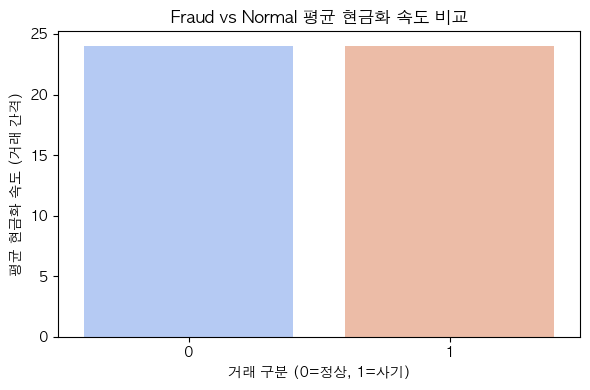

In [ ]:
# 평균 기준 요약 시각화
summary_turnover = user_turnover.groupby("isFraud")["avg_turnover_time"].agg(["mean", "median", "count"]).reset_index()

plt.figure(figsize=(6,4))
sns.barplot(
    data=summary_turnover,
    x="isFraud",
    y="mean",
    palette="coolwarm"
)

plt.title("Fraud vs Normal 평균 현금화 속도 비교", fontsize=12)
plt.xlabel("거래 구분 (0=정상, 1=사기)")
plt.ylabel("평균 현금화 속도 (거래 간격)")
plt.tight_layout()
plt.show()

### 현금화 속도 분석 결과
- 정상 거래와 사기 거래의 평균 현금화 속도는 **거의 동일(약 24단계)** 하게 나타남.  
- 즉, 사기 거래가 **더 빠르게 현금화된다거나, 지연된다**는 뚜렷한 패턴은 관찰되지 않음.  
- 이는 **PaySim 데이터셋의 시간 단위(step)** 가 하루 단위가 아닌 **시뮬레이션 시퀀스 단위**로 설계되어 있어, 실제 금융거래의 시간 차이를 반영하지 못한 결과로 해석됨.

### ✅ 결론  
- **현금화 속도는 Paysim 데이터셋의 Fraud 탐지에 있어 결정적인 변수로 작용하지 않는다.**  
- 대신 자금의 **유입·유출 구조**나 **경로 집중도(Pathway Pattern)** 와 결합해 **복합적 이상 패턴 탐지(Structural Anomaly Detection)** 방향으로 활용하는 것이 바람직하다.